In [11]:
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import zarr as zr
import xarray as xr
import django
from dask.distributed import Client, progress
import json
import dask_image.ndfilters

django.setup()
from elements.models import Representation
from transformers.models import Transforming

In [8]:
trans = Transforming.objects.first()

In [44]:
maxisp = trans.representation.array.sel(t=0).compute(scheduler="threads")

In [13]:
vectors = json.loads(trans.roi.vectors)

In [43]:
import larvik.extenders

2020-03-05 16:53:53,916 [larvik.extenders] INFO     Making DataArrays Look Beautiful
2020-03-05 16:53:53,918 [larvik.extenders] INFO     Extending DataArray


In [49]:
from elements.models import Transformation

In [58]:
trans = Transformation.objects.all().last()

In [61]:
trans.representation.sample.id

1

In [65]:
trans.array.biometa.channels.compute()

,Index,Name,EmissionWavelength,ExcitationWavelength,IlluminationType,AcquisitionMode,Color,SamplesPerPixel
0,0,Ch1-T1,518.0,488.0,Epifluorescence,LaserScanningConfocalMicroscopy,16711935,1
1,1,Ch1-T2,585.0,555.0,Epifluorescence,LaserScanningConfocalMicroscopy,-16776961,1


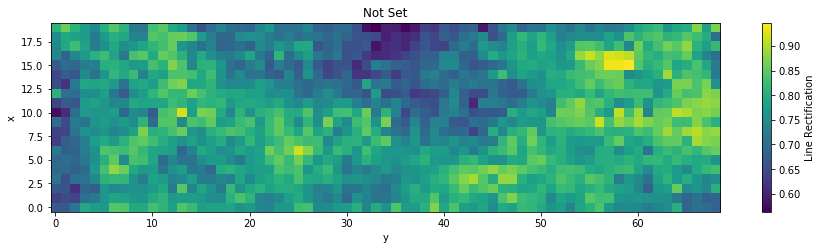

In [59]:
trans.array.biom

In [48]:
y = float(maxisp.biometa.scan["PhysicalSizeX"])
x = float(maxisp.biometa.scan["PhysicalSizeY"])

0.049345442271087926

In [35]:
import cv2
from transformers.logic.linerectifier_logic import translateImageFromLine

array = np.float64(maxisp)
image, boxwidths, pixelwidths, boxes = translateImageFromLine(array, vertices, settings.get("scale", 10))

ModuleNotFoundError: No module named 'cv2'

In [22]:
scale = 10

def getScaledOrtho(vertices, scale):
    '''Gets the 2D Orthogonal do the vertices provided'''
    perp = np.empty_like(vertices)
    perp[0] = -vertices[1]
    perp[1] = vertices[0]

    perpnorm = perp / np.linalg.norm(perp)
    perpscaled = perpnorm * scale
    return perpscaled





line = np.array([[item["x"],item["y"]] for item in vectors])
boxes = []
boxeswidths = []
for pos in range(len(line)-1):
    a = line[pos]
    b = line[pos+1]

    if a[0] != b[0] or a[1] != b[1]:
        perpnew = getScaledOrtho(a - b, scale=scale)

        c1 = a + perpnew
        c2 = a - perpnew
        c3 = b - perpnew
        c4 = b + perpnew
        width = np.linalg.norm(a - b)
        verts = [c1, c2, c3, c4]

        boxes.append(verts)
        boxeswidths.append(width)

boxes,boxeswidths

([[array([108.41020921, 135.66654394]),
   array([115.58979079, 154.33345606]),
   array([128.58979079, 149.33345606]),
   array([121.41020921, 130.66654394])],
  [array([122.25278872, 130.38476052]),
   array([127.74721128, 149.61523948]),
   array([134.74721128, 147.61523948]),
   array([129.25278872, 128.38476052])],
  [array([130.75965265, 128.07722123]),
   array([133.24034735, 147.92277877]),
   array([141.24034735, 146.92277877]),
   array([138.75965265, 127.07722123])],
  [array([138.89568474, 127.06116265]),
   array([141.10431526, 146.93883735]),
   array([150.10431526, 145.93883735]),
   array([147.89568474, 126.06116265])],
  [array([149., 126.]),
   array([149., 146.]),
   array([155., 146.]),
   array([155., 126.])],
  [array([149.45299804, 127.67949706]),
   array([160.54700196, 144.32050294]),
   array([163.54700196, 142.32050294]),
   array([152.45299804, 125.67949706])]],
 [13.92838827718412,
  7.280109889280518,
  8.06225774829855,
  9.055385138137417,
  6.0,
  3.605

In [24]:
boxes

[[array([108.41020921, 135.66654394]),
  array([115.58979079, 154.33345606]),
  array([128.58979079, 149.33345606]),
  array([121.41020921, 130.66654394])],
 [array([122.25278872, 130.38476052]),
  array([127.74721128, 149.61523948]),
  array([134.74721128, 147.61523948]),
  array([129.25278872, 128.38476052])],
 [array([130.75965265, 128.07722123]),
  array([133.24034735, 147.92277877]),
  array([141.24034735, 146.92277877]),
  array([138.75965265, 127.07722123])],
 [array([138.89568474, 127.06116265]),
  array([141.10431526, 146.93883735]),
  array([150.10431526, 145.93883735]),
  array([147.89568474, 126.06116265])],
 [array([149., 126.]),
  array([149., 146.]),
  array([155., 146.]),
  array([155., 126.])],
 [array([149.45299804, 127.67949706]),
  array([160.54700196, 144.32050294]),
  array([163.54700196, 142.32050294]),
  array([152.45299804, 125.67949706])]]

In [28]:
def getPerspectiveTransform(sourcePoints, destinationPoints):
    """
    Calculates the 3x3 matrix to transform the four source points to the four destination points

    Comment copied from OpenCV:
    /* Calculates coefficients of perspective transformation
    * which maps soruce (xi,yi) to destination (ui,vi), (i=1,2,3,4):
    *
    *      c00*xi + c01*yi + c02
    * ui = ---------------------
    *      c20*xi + c21*yi + c22
    *
    *      c10*xi + c11*yi + c12
    * vi = ---------------------
    *      c20*xi + c21*yi + c22
    *
    * Coefficients are calculated by solving linear system:
    *             a                         x    b
    * / x0 y0  1  0  0  0 -x0*u0 -y0*u0 \ /c00\ /u0\
    * | x1 y1  1  0  0  0 -x1*u1 -y1*u1 | |c01| |u1|
    * | x2 y2  1  0  0  0 -x2*u2 -y2*u2 | |c02| |u2|
    * | x3 y3  1  0  0  0 -x3*u3 -y3*u3 |.|c10|=|u3|,
    * |  0  0  0 x0 y0  1 -x0*v0 -y0*v0 | |c11| |v0|
    * |  0  0  0 x1 y1  1 -x1*v1 -y1*v1 | |c12| |v1|
    * |  0  0  0 x2 y2  1 -x2*v2 -y2*v2 | |c20| |v2|
    * \  0  0  0 x3 y3  1 -x3*v3 -y3*v3 / \c21/ \v3/
    *
    * where:
    *   cij - matrix coefficients, c22 = 1
    */

    """
    if sourcePoints.shape != (4,2) or destinationPoints.shape != (4,2):
        raise ValueError("There must be four source points and four destination points")

    a = np.zeros((8, 8))
    b = np.zeros((8))
    for i in range(4):
        a[i][0] = a[i+4][3] = sourcePoints[i][0]
        a[i][1] = a[i+4][4] = sourcePoints[i][1]
        a[i][2] = a[i+4][5] = 1
        a[i][3] = a[i][4] = a[i][5] = 0
        a[i+4][0] = a[i+4][1] = a[i+4][2] = 0
        a[i][6] = -sourcePoints[i][0]*destinationPoints[i][0]
        a[i][7] = -sourcePoints[i][1]*destinationPoints[i][0]
        a[i+4][6] = -sourcePoints[i][0]*destinationPoints[i][1]
        a[i+4][7] = -sourcePoints[i][1]*destinationPoints[i][1]
        b[i] = destinationPoints[i][0]
        b[i+4] = destinationPoints[i][1]

    x = np.linalg.solve(a, b)
    x.resize((9,), refcheck=False)
    x[8] = 1 # Set c22 to 1 as indicated in comment above
    return x.reshape((3,3))

In [30]:
for box in boxes:
    height = scale * 2
    width = np.linalg.norm(box[1] - box[2])

    pts1 = np.float32(box)
    pts2 = np.float32([[0, height], [0, 0], [width, 0], [width, height]])
    
    M = getPerspectiveTransform(pts1, pts2)
    print(M)

[[ 9.33350128e-01 -3.58980994e-01 -5.24829701e+01]
 [-3.58980798e-01 -9.33350623e-01  1.85541737e+02]
 [ 1.83528254e-08  2.03292848e-08  1.00000000e+00]]
[[ 9.61524004e-01 -2.74720926e-01 -8.17295709e+01]
 [-2.74721290e-01 -9.61524515e-01  1.78953593e+02]
 [-1.34064685e-17 -2.51371893e-18  1.00000000e+00]]
[[ 9.92277949e-01 -1.24034171e-01 -1.13863974e+02]
 [-1.24034787e-01 -9.92278297e-01  1.63306997e+02]
 [ 1.09314277e-17 -1.36642013e-18  1.00000000e+00]]
[[ 9.93883854e-01 -1.10430904e-01 -1.24014705e+02]
 [-1.10431516e-01 -9.93883643e-01  1.61622475e+02]
 [-1.08314449e-18 -9.74830045e-18  1.00000000e+00]]
[[ 1.00000000e+00 -0.00000000e+00 -1.49000000e+02]
 [-9.16829336e-16 -1.00000000e+00  1.46000000e+02]
 [-1.48029737e-17  0.00000000e+00  1.00000000e+00]]
[[ 8.32050404e-01 -5.54700015e-01 -5.35286127e+01]
 [-5.54700509e-01 -8.32050764e-01  2.09137480e+02]
 [-3.41607245e-16 -2.01548420e-16  1.00000000e+00]]


In [17]:
from scipy.ndimage import affine_transform